## Baseline CNN model
### [Kaggle - Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data)

This notebook references code by Kaggle user [angqx95](https://www.kaggle.com/code/angqx95/feature-extractor-fine-tuning-with-keras) on https://www.kaggle.com/code/angqx95/feature-extractor-fine-tuning-with-keras. 

## Unzipping datasets

In [10]:
#Define some constants
sample_path = "./drive/MyDrive/Colab Notebooks/"
train_ds = "train.zip"

batch_size = 32
img_size = 256
epochs = 5

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model,Sequential

from sklearn.model_selection import train_test_split


In [2]:
import zipfile
import os
# extract ZIP into the folder
with zipfile.ZipFile(os.path.join(sample_path, train_ds),"r") as zip_ref:
  zip_ref.extractall("/tmp/dog_v_cats/")

In [3]:
# below is to correct the dataset path 
train_ds_dir = "/tmp/dog_v_cats/train/"

print("There are ", len(os.listdir('/tmp/dog_v_cats/train')), "training data samples")

There are  25000 training data samples


## Data Formatting
Labels: 1 for dog, 0 for cat.

In [6]:

def generate_paths_n_labels(directory):
  ground_truth_labels = []  # '0' or '1' for cat and dog, respectively
  img_paths = []  # the relative path of this image file 
  for file in os.listdir(directory):
    img_paths.append(file)
    if (file.split('.')[0] == 'cat'):
      ground_truth_labels.append('0')
    else:
      ground_truth_labels.append('1')
  print(len(ground_truth_labels), "images scanned at", directory)
  return img_paths, ground_truth_labels


train_img_paths, train_y = generate_paths_n_labels(train_ds_dir)

25000 images scanned at /tmp/dog_v_cats/train/


        filename class_label
0   cat.7725.jpg           0
1   cat.1508.jpg           0
2  cat.12040.jpg           0
3   cat.4954.jpg           0
4  dog.11784.jpg           1


Text(0.5, 1.0, 'Cats vs. Dogs Images Distribution')

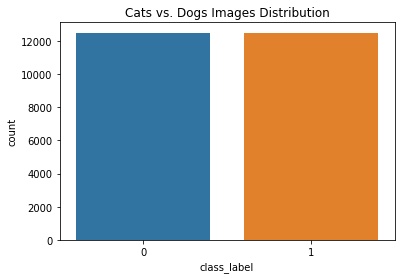

In [8]:
df = pd.DataFrame({'filename': train_img_paths,
                  'class_label': train_y})
print(df.head())

# showing the data distribution in the training set
sns.countplot(x='class_label',data=df).set_title("Cats vs. Dogs Images Distribution")

In [ ]:
#### FYI #####
# Showing one image 
img = load_img(os.path.join( train_ds_dir, df['filename'].iloc[0]))

plt.figure(figsize=(8, 8))
plt.imshow(img)
##############

## Train-Validation Split

In [15]:
def generate_img_batch(dataframe, ds_dir): 
  '''dataframe : contains 2 cols, <path to image file>, <label for the image>
     ds_dir = directory path on which  <path to image file> is based
  '''
  data_genarator = ImageDataGenerator(    # data augmentation
                rescale=1./255,  # rescale to [0, 1]
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True
                # preprocessing_function = 
                )
  train_data_gen = data_genarator.flow_from_dataframe(
                dataframe,
                directory=ds_dir,
                x_col='filename',
                y_col='class_label',
                target_size=(img_size, img_size),
                batch_size = batch_size,
                class_mode='binary',
                interpolation='nearest'
                )

  return train_data_gen


In [16]:
# make data for validation set (accounts for 25% of all data)
train_df, valid_df = train_test_split(df, test_size=0.25) 

train_gen = generate_img_batch(train_df, train_ds_dir) # training dataset generator
valid_gen = generate_img_batch(valid_df, train_ds_dir) #  validation dataset generator

print("size of training dataset: %d" % (train_df.shape[0]))
print("size of validation dataset: %d" % (valid_df.shape[0]))

Found 18750 validated image filenames belonging to 2 classes.
Found 6250 validated image filenames belonging to 2 classes.
size of training dataset: 18750
size of validation dataset: 6250


## Model training

In [22]:
from keras import backend as K
K.clear_session()

In [30]:
#model instantiation
model=Sequential()
model.add(Conv2D(16, (3,3), activation="relu", input_shape=(img_size, img_size, 3)))
model.add(Conv2D(16, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (3,3)))

model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (3,3), strides=(2,2), activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", 
         # optimizer=optimizers.RMSprop(lr=1e-4),
         optimizer=RMSprop(learning_rate=1e-4),
         metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 conv2d_36 (Conv2D)          (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 84, 84, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 82, 82, 32)        4640      
                                                                 
 conv2d_38 (Conv2D)          (None, 80, 80, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                 

In [31]:
model.fit_generator(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
1172/1172 [==============================] - 373s 317ms/step - loss: 0.6586 - accuracy: 0.5988 - val_loss: 0.6246 - val_accuracy: 0.6480
Epoch 2/5
1172/1172 [==============================] - 371s 316ms/step - loss: 0.5941 - accuracy: 0.6793 - val_loss: 0.5589 - val_accuracy: 0.7141
Epoch 3/5
1172/1172 [==============================] - 368s 314ms/step - loss: 0.5370 - accuracy: 0.7301 - val_loss: 0.5710 - val_accuracy: 0.7016
Epoch 4/5
1172/1172 [==============================] - 366s 313ms/step - loss: 0.5035 - accuracy: 0.7535 - val_loss: 0.5528 - val_accuracy: 0.7218
Epoch 5/5
1172/1172 [==============================] - 367s 313ms/step - loss: 0.4774 - accuracy: 0.7731 - val_loss: 0.4638 - val_accuracy: 0.7806


In [32]:
loss, accuracy = model.evaluate_generator(valid_gen, valid_gen.samples//batch_size, workers=12)
print("Validation: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Validation: accuracy = 0.785417  ;  loss = 0.464272 


In [33]:
model.save(filepath="/content/drive/MyDrive/Colab Notebooks/CustomCNN_baseline.h5",
              include_optimizer=True)
